# Early Stopping

El método de early stoppin es un método de regularización que se basa en evaluar los datos sobre un conjunto de validación para evitar que haya sobre ajuste, guardando los pesos de la red antes del sobre-ajuste.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_digits

## Definición de la red

Definimos una arquitectura simple de red. Además dentro del módulo incorporamos la fase de entrenamiento y el cálculo del riesgo para facilitar su uso.

In [2]:
class FeedForward(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_units=100):
        super().__init__()
        self.ffw = nn.Sequential(nn.Linear(n_inputs, hidden_units), nn.Tanh(),
                                 nn.Linear(hidden_units, n_outputs), nn.Softmax(1))
        self.risk_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.ffw.parameters(), lr=0.1)
    
    def forward(self, x):
        f = self.ffw(x)
        
        return f
        
    def loss(self, x, y):
        """Cálculo del riesgo"""
        result = self.forward(x)
        
        return float(self.risk_function(result, y).detach().numpy())
    
    def train(self, x, y, epochs=1):
        """Entrenamiento de la red"""
        for i in range(epochs):
            y_hat = self.forward(x)
            self.optimizer.zero_grad()
            loss = self.risk_function(y_hat, y_train)
            loss.backward()
            self.optimizer.step()

## Preparación de los datos

Usamos el dataset de MNIST para hacer clasificación en 10 clases (digitos).

In [3]:
data = load_digits()
X = torch.Tensor(data.data)
Y = torch.LongTensor(data.target)

print(data.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Los datos deben separarse en 3 subconjuntos: entrenamiento, validación y evaluación. La validación la tomamos de la parte del entrenamiento. La validación servirá para evaluar el error de generalziación en las iteraciones del entrenamiento.

In [4]:
x_train1, x_test, y_train1, y_test = train_test_split(X,Y, test_size=0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train1,y_train1, test_size=0.1)

print('Train: {}, Validation: {}, Test: {}'.format(len(x_train), len(x_val), len(x_test)))
print('Train: {}, Validation: {}, Test: {}'.format(len(y_train), len(y_val), len(y_test)))

Train: 1131, Validation: 126, Test: 540
Train: 1131, Validation: 126, Test: 540


### Modelo

Obtenemos el modelo de la red:

In [5]:
model = FeedForward(n_inputs=64,n_outputs=10)

## Aplicación de early stopping

El early stopping buscará los pesos de la red que minimicen no sólo el error de entrenamiento, sino tambień el de validación. Guardára cada cierto tiempo los pesos y revisará si comienza a haber o no overfitting. Cuando los pesos de validación suben, aunque el entrenamiento sigue bajando, el algoritmo se dentendrá después de esperar un $p$ número de pasos o paciencia.

In [6]:
train = []
val = []
train_acc = []
val_acc = []

#Pasos entre evaluaciones
s = 10
#Paciencoa
p = 100
#Variables de pasos
i, j = 0, 0
#Riesgo inicial
err = np.inf
#Pesos óptimos iniciales
weight_opt = model.state_dict()
#Épocas óptimas iniciales
i_opt = i
while j < p:
    #Entrena el modelo
    model.train(x_train, y_train, epochs=s)
    weight = model.state_dict()
    #Riesgo de entrenamiento
    risk = model.loss(x_train, y_train)
    #Aumenta épocas por número de pasos
    i += s
    #Riesgo de validación
    err_val = model.loss(x_val, y_val)
    
    #Guarda riesgos y accuracies
    train.append(risk)
    val.append(err_val)
    train_acc.append(accuracy_score(y_train, model(x_train).argmax(axis=1)))
    val_acc.append(accuracy_score(y_val, model(x_val).argmax(axis=1)))
    
    if err_val < err:
        #Si se reduce el riesgo de validación
        j, i_opt = 0, i
        #actualiza el nuevo riesgo
        err = err_val
        #guarda los pesos óptimos
        weight_opt = weight
        
        print('Error en entrenamiento {},  Error en validación {}'.format(risk, err_val))
    else:
        j += 1

Error en entrenamiento 2.26888108253479,  Error en validación 2.241121292114258
Error en entrenamiento 2.2507166862487793,  Error en validación 2.2309203147888184
Error en entrenamiento 2.240143299102783,  Error en validación 2.2189126014709473
Error en entrenamiento 2.2403218746185303,  Error en validación 2.2184784412384033
Error en entrenamiento 2.233842611312866,  Error en validación 2.213031530380249
Error en entrenamiento 2.2320868968963623,  Error en validación 2.2113468647003174


Podemos recuperar el número de épocas óptimas para alcanzar el menor riesgo de validación.

In [7]:
print(i_opt)

80


### Visualización del comportamiento de entrenamiento y validación

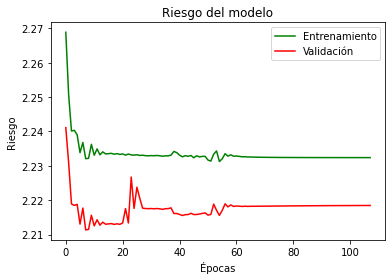

In [8]:
plt.plot(train, 'g', label='Entrenamiento')
plt.plot(val, 'r', label='Validación')
plt.legend(loc='upper right')
plt.title('Riesgo del modelo')
plt.xlabel('Épocas')
plt.ylabel('Riesgo')
plt.show()

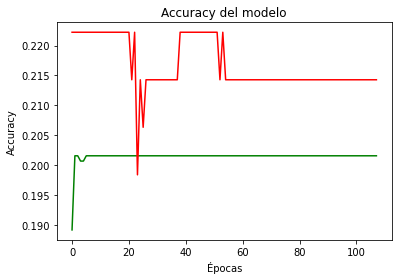

In [9]:
plt.plot(train_acc, 'g', label='Entrenamiento')
plt.plot(val_acc, 'r', label='Validación')
plt.title('Accuracy del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.show()

### Evaluación del modelo

Evaluamos el modelo usando los pesos óptimos:

In [11]:
#Cargamos los pesos óptimos
model.load_state_dict(weight_opt)
#Aplicamos el modelo con pesos óptimos
y_hat = model(x_val).argmax(axis=1)

#Evaluamos
print(classification_report(y_val,y_hat))
print(model.loss(x_val, y_val))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        13
           2       0.81      0.94      0.87        18
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        12
           5       0.10      1.00      0.17        10
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        11

    accuracy                           0.21       126
   macro avg       0.09      0.19      0.10       126
weighted avg       0.12      0.21      0.14       126

2.218461275100708
